In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MetricCollection, MeanSquaredError

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule, MyLightningModule
from utils.postprocess import dynamic_range_nms
from torch_models.dataset import ZzzPatchIndexedDataset
from torch_models.models import ZzzTransformerGRUModel
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD

MODEL_NAME = "patch_transformer_gru"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-10-29 16:17:27.386255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-29 16:17:27.386378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-29 16:17:27.386384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_105


In [3]:
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
sid2fold = dict(zip(cv_split["series_id"], cv_split["fold"]))

files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
sid2df = {}
for file in tqdm(files):
    df = pd.read_parquet(file)
    df = df.sort_values("step").reset_index(drop=True)

    # 標準化
    df["anglez"] = (df["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
    df["enmo"] = (df["enmo"] - ENMO_MEAN) / ENMO_STD
    df["anglez_diff"] = df["anglez"].diff().fillna(0)
    df["enmo_diff"] = df["enmo"].diff().fillna(0)

    # targetは01にする
    df["onset_target"] = df["onset_target"] / 10
    df["wakeup_target"] = df["wakeup_target"] / 10

    # cv
    sid = df["series_id"].unique()[0]
    df["fold"] = sid2fold[sid]

    sid2df[sid] = df
gc.collect()

100%|██████████| 277/277 [00:53<00:00,  5.15it/s]


3431

In [4]:
# BLOCK_SIZE ごとに分割
samples = []
for series_id in tqdm(sorted(sid2df.keys())):
    df = sid2df[series_id]
    fold = df.iloc[0]["fold"]

    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0

        samples.append({
            "series_id": series_id,
            "start": start,
            "end": end,
            "fold": fold,
        })
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
dataset_oof = ZzzPatchIndexedDataset(sid2df, samples=samples, mode='train', features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:02<00:00, 99.37it/s] 


((1600, 48), (1600, 2))

In [5]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [6]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_samples = [sample for sample in samples if sample["fold"] != fold]
    valid_samples = [sample for sample in samples if sample["fold"] == fold]
    train_dataset = ZzzPatchIndexedDataset(sid2df, samples=train_samples, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchIndexedDataset(sid2df, samples=valid_samples, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    
    model = ZzzTransformerGRUModel(
        max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
    )
    pl_model = MyLightningModule(
        model=model,
        lr=0.001, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
    )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=8,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        )
    trainer.fit(pl_model, datamodule=data_module)

    # 推論
    pl_model = MyLightningModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        model=model,
    ).to("cuda")
    pl_model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(pl_model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    ps = CFG[MODEL_NAME]["execution"]["patch_size"]
    for pred, sample in zip(np.vstack(preds), valid_samples):
        sid = sample["series_id"]
        start = sample["start"]
        end = sample["end"]
        df = sid2df[sid].iloc[start + ps // 2: end: ps][["series_id", "step"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7655, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0585, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0248, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0228, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0216, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0207, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0207, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0212, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6331, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0513, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0199, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0175, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0171, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0174, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0172, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0172, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0167, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0167, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0171, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0167, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0165, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0171, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0170, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0168, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0169, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0171, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0175, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0178, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0173, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.5955, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0577, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0217, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0201, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0202, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0196, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0195, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0199, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0195, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0194, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0199, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0197, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0198, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0200, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0203, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0202, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: BCEWithLogitsLoss=0.0216, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.8198, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0535, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0227, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0216, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0216, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0217, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0218, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0293, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0284, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0280, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0281, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0304, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0289, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6170, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0579, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0235, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0221, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0203, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0210, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0211, 
CPU times: user 5h 18s, sys: 5min 21s, total: 5h 5min 40s
Wall time: 2h 18min 8s


0

1026458

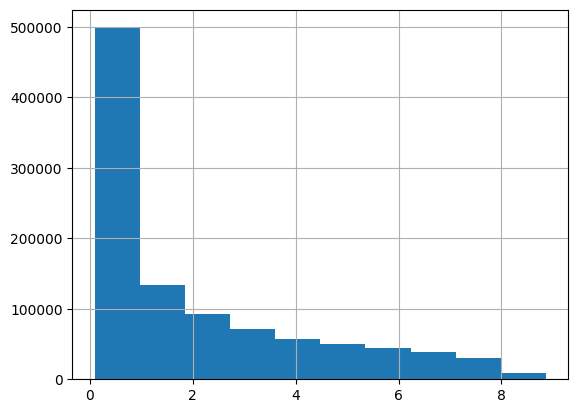

In [7]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [8]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:11<00:00, 25.16it/s]


In [9]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7708


event   tolerance
onset   12           0.244378
        36           0.643318
        60           0.745968
        90           0.792522
        120          0.832981
        150          0.849723
        180          0.867986
        240          0.884260
        300          0.892671
        360          0.900137
wakeup  12           0.364104
        36           0.640537
        60           0.745275
        90           0.788792
        120          0.827151
        150          0.843969
        180          0.863449
        240          0.881703
        300          0.898179
        360          0.908564
dtype: float64

In [10]:
%cp -r logs {CFG["output_dir"]}